<a href="https://colab.research.google.com/github/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/skin_condition_image_classifier_final_notebook_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dependencies
import os, shutil
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.image as mpimg
import pickle


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
func_path = '/content/drive/MyDrive/Colab Notebooks/' 
sys.path.append(os.path.abspath(func_path))
from capstone_funcs import visualize_images, preprocessing_dense_data, visualize_nn, visualize_nn_test, nn_model, cnn_preprocessing, visualize_cnn, visualize_cnn_test, cnn_model

In [4]:
# Filepaths
train_dir = '/content/drive/MyDrive/Colab Notebooks/dermoscopic_images/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/dermoscopic_images/test/' 

# Check functionality and num images
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
train_unknown_dir = os.path.join(train_dir, 'unknown')
train_benign_dir

test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')
test_unknown_dir = os.path.join(test_dir, 'unknown')

In [5]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [ ]:
# Check number of files
print('There are', len(os.listdir(train_benign_dir)), 'benign images in the training set')
print('There are', len(os.listdir(train_malignant_dir)), 'malignant images in the training set')
print('There are', len(os.listdir(train_unknown_dir)), 'unknown images in the training set')
print('')
print('There are', len(os.listdir(test_benign_dir)), 'benign images in the testing set')
print('There are', len(os.listdir(test_malignant_dir)), 'malignant images in the testing set')
print('There are', len(os.listdir(test_unknown_dir)), 'unknown images in the testing set')

There are 2401 benign images in the training set
There are 1500 malignant images in the training set
There are 1500 unknown images in the training set

There are 600 benign images in the testing set
There are 600 malignant images in the testing set
There are 579 unknown images in the testing set


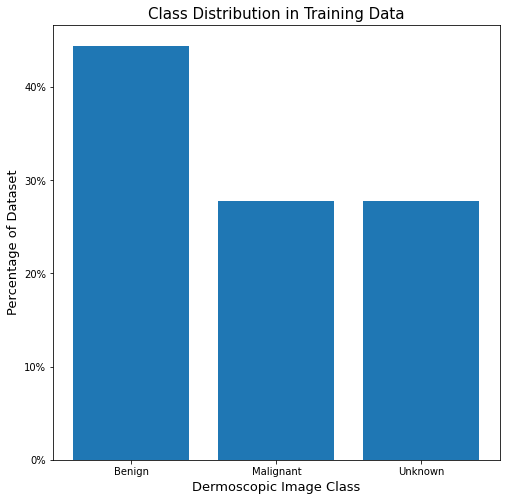

In [ ]:
# Visualize class distribution in training data
total_images = len(os.listdir(train_benign_dir)) + len(os.listdir(train_malignant_dir)) + len(os.listdir(train_unknown_dir))
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Benign', 'Malignant', 'Unknown'], height=[len(os.listdir(train_benign_dir))/total_images, 
                                          len(os.listdir(train_malignant_dir))/total_images,
                                          len(os.listdir(train_unknown_dir))/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('Dermoscopic Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

In [ ]:
# Creating a list containing the path to each image in the subsets of the training data
train_benign_filepaths = [os.path.join(train_benign_dir, name) for name in os.listdir(train_benign_dir)]
train_malignant_filepaths = [os.path.join(train_malignant_dir, name) for name in os.listdir(train_malignant_dir)]
train_unknown_filepaths = [os.path.join(train_unknown_dir, name) for name in os.listdir(train_unknown_dir)]

In [ ]:
# Loading in ten images from each subset of the training data
tr_benign_images = [mpimg.imread(img) for img in train_benign_filepaths[:10]]
tr_malignant_images = [mpimg.imread(img) for img in train_malignant_filepaths[:10]]
tr_unknown_images = [mpimg.imread(img) for img in train_unknown_filepaths[:10]]

In [ ]:
images = [(tr_benign_images, 'Benign'), (tr_malignant_images, 'Malignant'), (tr_unknown_images, 'Unknown')]

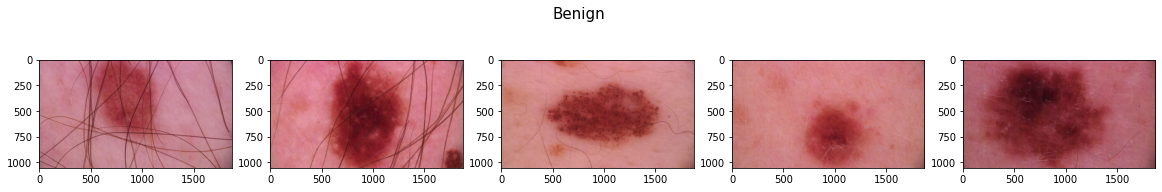

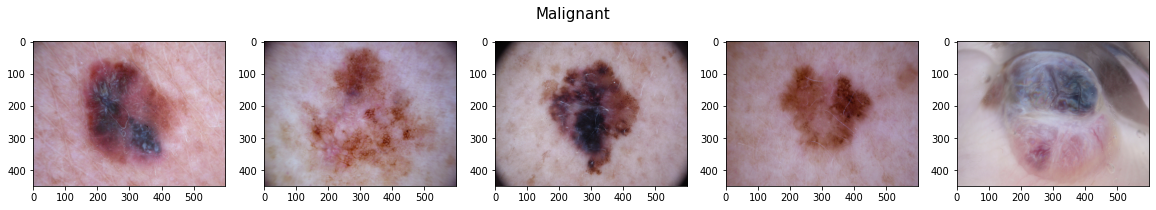

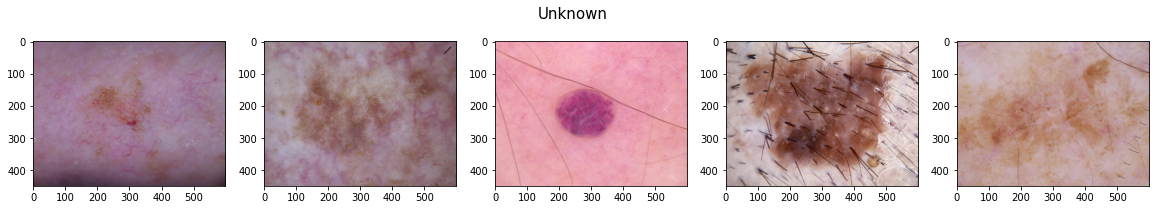

In [ ]:
for im, name in images:
    visualize_images(im, name)

In [ ]:
train_gen, val_gen = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
model = models.Sequential()
model.add(Flatten(input_shape=(128,128,3)))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Recall'])

history=model.fit(train_gen,
                  steps_per_epoch=33,
                  epochs=5,
                  validation_data=val_gen,
                  validation_steps=8)

Epoch 1/5
33/33 [==============================] - 2713s 84s/step - loss: 1.4941 - accuracy: 0.4305 - recall: 0.0250 - val_loss: 1.0942 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 2/5
33/33 [==============================] - 322s 10s/step - loss: 1.0930 - accuracy: 0.4441 - recall: 0.0000e+00 - val_loss: 1.0893 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 3/5
33/33 [==============================] - 314s 10s/step - loss: 1.0892 - accuracy: 0.4438 - recall: 0.0000e+00 - val_loss: 1.0848 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 4/5
33/33 [==============================] - 315s 10s/step - loss: 1.0855 - accuracy: 0.4460 - recall: 0.0000e+00 - val_loss: 1.0806 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 5/5
33/33 [==============================] - 316s 10s/step - loss: 1.0824 - accuracy: 0.4460 - recall: 0.0000e+00 - val_loss: 1.0769 - val_accuracy: 0.4688 - val_recall: 0.0000e+00


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1572896   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 1,573,187
Trainable params: 1,573,187
Non-trainable params: 0
_________________________________________________________________


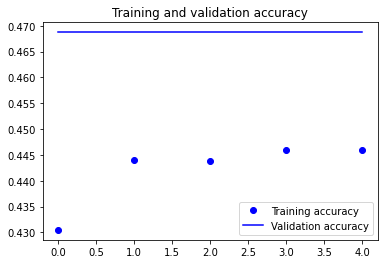

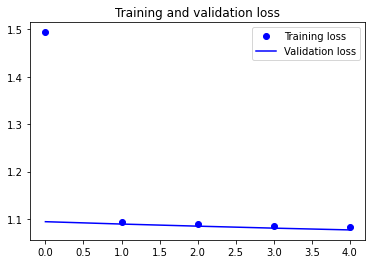

<Figure size 432x288 with 0 Axes>


Training Evaluation:
34/34 [==============================] - 185s 5s/step - loss: 1.0812 - accuracy: 0.4446 - recall: 0.0000e+00

Validation Evaluation:
9/9 [==============================] - 136s 16s/step - loss: 1.0813 - accuracy: 0.4444 - recall: 0.0000e+00

Test Confusion Matrix



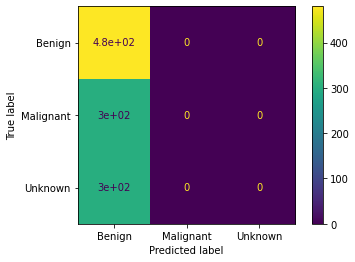

In [ ]:
visualize_nn(history, model, train_gen, val_gen, multi=True, labels=['Benign', 'Malignant', 'Unknown'])

In [ ]:
train_gen_cnn, val_gen_cnn = cnn_preprocessing(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
checkpoint_filepath_cnn='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model.h5'
my_callback_cnn=ModelCheckpoint(filepath=checkpoint_filepath_cnn, monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
cnn_model = models.Sequential()

cnn_model.add(Conv2D(256, kernel_size=(5,5), activation='relu',input_shape=(128,128,3)))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(64, kernel_size=(3,3), kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, kernel_size=(5,5), kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(l2=0.001)))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2=0.001)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(3, activation='softmax'))
            
            
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'Recall'])
            

cnn_history = cnn_model.fit(train_gen_cnn,
                            steps_per_epoch=33,
                            epochs=25,
                            validation_data=(val_gen_cnn),
                            validation_steps=8,
                            callbacks=my_callback_cnn)

Epoch 1/25
33/33 [==============================] - 280s 8s/step - loss: 1.3938 - accuracy: 0.6010 - recall: 0.2213 - val_loss: 1.4594 - val_accuracy: 0.4717 - val_recall: 9.7656e-04
Epoch 2/25
33/33 [==============================] - 273s 8s/step - loss: 1.1901 - accuracy: 0.7262 - recall: 0.3694 - val_loss: 1.3295 - val_accuracy: 0.4727 - val_recall: 0.4668
Epoch 3/25
33/33 [==============================] - 272s 8s/step - loss: 1.0671 - accuracy: 0.7613 - recall: 0.4310 - val_loss: 1.2192 - val_accuracy: 0.4932 - val_recall: 0.4648
Epoch 4/25
33/33 [==============================] - 273s 8s/step - loss: 0.9616 - accuracy: 0.7901 - recall: 0.4891 - val_loss: 1.2925 - val_accuracy: 0.3857 - val_recall: 0.0498
Epoch 5/25
33/33 [==============================] - 273s 8s/step - loss: 0.8735 - accuracy: 0.8111 - recall: 0.5402 - val_loss: 1.3340 - val_accuracy: 0.2734 - val_recall: 0.1113
Epoch 6/25
33/33 [==============================] - 273s 8s/step - loss: 0.7963 - accuracy: 0.8137 - 

In [ ]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/cnn_model.h5')

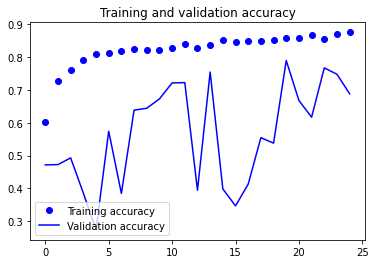

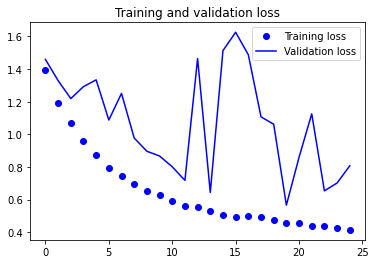

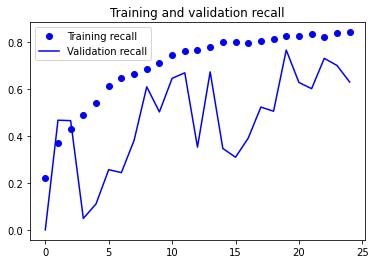


Training Evaluation:
34/34 [==============================] - 161s 5s/step - loss: 0.7584 - accuracy: 0.7278 - recall: 0.6765

Validation Evaluation:
9/9 [==============================] - 118s 14s/step - loss: 0.8021 - accuracy: 0.6843 - recall: 0.6269

Validation Confusion Matrix



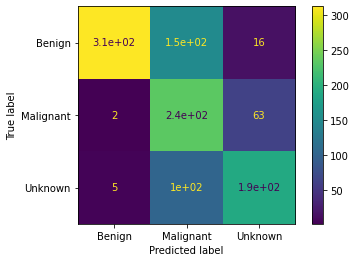

In [ ]:
visualize_cnn(cnn_history, cnn_model, train_gen_cnn, val_gen_cnn, multi=True, labels=['Benign', 'Malignant', 'Unknown'])

In [ ]:
train_gen_transfer, val_gen_transfer = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
checkpoint_filepath='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model1.h5'
my_callback=ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_recall', save_best_only=True, mode='max')

In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
for layers in base_model.layers:
  layers.trainable=False

transfer_model = models.Sequential()

transfer_model.add(base_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2=0.001)))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
transfer_model.add(BatchNormalization())
transfer_model.add(Activation('relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
transfer_model.add(BatchNormalization())
transfer_model.add(Activation('relu'))
transfer_model.add(Dense(3, activation='softmax'))
            
            
transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'Recall'])
            

transfer_history = transfer_model.fit(train_gen_transfer,
                                      steps_per_epoch=33,
                                      epochs=25,
                                      validation_data=(val_gen_transfer),
                                      validation_steps=8,
                                      callbacks=my_callback)

Epoch 1/25
33/33 [==============================] - 340s 10s/step - loss: 1.3979 - accuracy: 0.3713 - recall: 0.1026 - val_loss: 1.1821 - val_accuracy: 0.4805 - val_recall: 0.2090
Epoch 2/25
33/33 [==============================] - 319s 10s/step - loss: 1.1590 - accuracy: 0.5230 - recall: 0.1073 - val_loss: 1.1137 - val_accuracy: 0.7051 - val_recall: 0.0518
Epoch 3/25
33/33 [==============================] - 316s 10s/step - loss: 1.0616 - accuracy: 0.6492 - recall: 0.1297 - val_loss: 1.0683 - val_accuracy: 0.7324 - val_recall: 0.0166
Epoch 4/25
33/33 [==============================] - 319s 10s/step - loss: 1.0081 - accuracy: 0.6897 - recall: 0.1462 - val_loss: 1.0189 - val_accuracy: 0.7305 - val_recall: 0.0498
Epoch 5/25
33/33 [==============================] - 315s 10s/step - loss: 0.9681 - accuracy: 0.7098 - recall: 0.1655 - val_loss: 1.0361 - val_accuracy: 0.6104 - val_recall: 0.0420
Epoch 6/25
33/33 [==============================] - 316s 10s/step - loss: 0.9258 - accuracy: 0.7379 

In [ ]:
transfer_model.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model.h5')

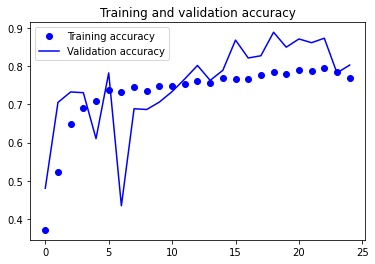

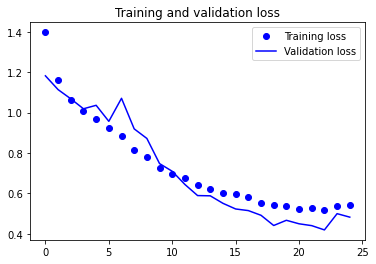

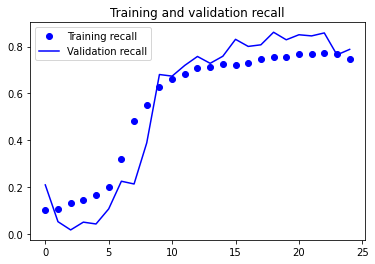


Training Evaluation:
34/34 [==============================] - 183s 5s/step - loss: 0.4656 - accuracy: 0.8336 - recall: 0.8243

Validation Evaluation:
9/9 [==============================] - 137s 16s/step - loss: 0.4836 - accuracy: 0.8120 - recall: 0.7981

Validation Confusion Matrix



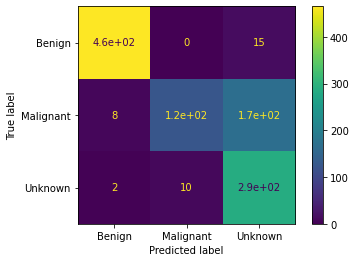

In [ ]:
visualize_cnn(transfer_history, transfer_model, train_gen_transfer, val_gen_transfer, multi=True, labels=['Benign', 'Malignant', 'Unknown'])


In [ ]:
train_gen_transfer2, val_gen_transfer2 = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
checkpoint_filepath2='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model2.h5'
my_callback2=ModelCheckpoint(filepath=checkpoint_filepath2, monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
base_model2 = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
for layers in base_model2.layers:
  layers.trainable=False

transfer_model2 = models.Sequential()

transfer_model2.add(base_model2)
transfer_model2.add(Flatten())
transfer_model2.add(Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(256, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dense(3, activation='softmax'))
            
            
transfer_model2.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'Recall'])
            

transfer_history2 = transfer_model2.fit(train_gen_transfer2,
                                        steps_per_epoch=33,
                                        epochs=35,
                                        validation_data=(val_gen_transfer2),
                                        validation_steps=8,
                                        callbacks=my_callback2)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/35
33/33 [==============================] - 3060s 93s/step - loss: 1.8580 - accuracy: 0.3876 - recall: 0.1271 - val_loss: 1.4770 - val_accuracy: 0.5518 - val_recall: 0.3066
Epoch 2/35
33/33 [==============================] - 304s 9s/step - loss: 1.3561 - accuracy: 0.5707 - recall: 0.1987 - val_loss: 1.1656 - val_accuracy: 0.6924 - val_recall: 0.5322
Epoch 3/35
33/33 [==============================] - 275s 8s/step - loss: 1.1680 - accuracy: 0.6537 - recall: 0.2764 - val_loss: 1.0162 - val_accuracy: 0.7002 - val_recall: 0.5166
Epoch 4/35
33/33 [==============================] - 273s 8s/step - loss: 1.0501 - accuracy: 0.6823 - recall: 0.3732 - val_loss: 1.0202 - val_accuracy: 0.7520 - val_recall: 0.4326
Epoch 5/35
33/33 [==============================] - 272s 8s/step - loss: 0.9625 - accuracy: 0.7167 - recall: 0.4448 - val_loss: 0.9903 - val_accuracy: 0.7266 - val_recall: 0.4678
Epoch 6/35
33/33 [====================

In [ ]:
transfer_model2.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model2.h5')

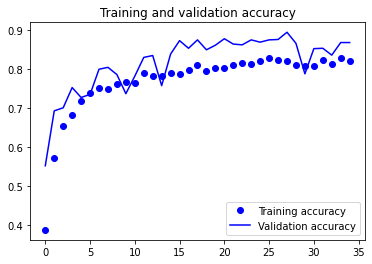

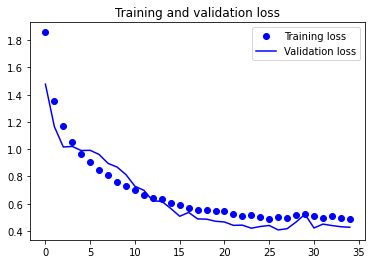

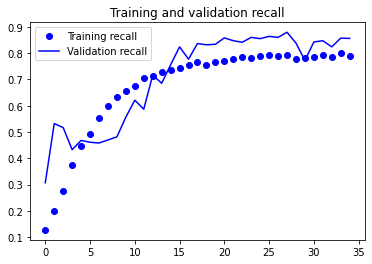


Training Evaluation:
34/34 [==============================] - 163s 5s/step - loss: 0.4164 - accuracy: 0.8729 - recall: 0.8637

Validation Evaluation:
9/9 [==============================] - 120s 14s/step - loss: 0.4378 - accuracy: 0.8630 - recall: 0.8528

Validation Confusion Matrix



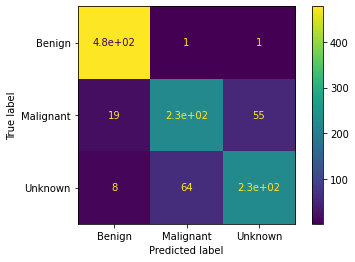

In [ ]:
visualize_cnn(transfer_history2, transfer_model2, train_gen_transfer2, val_gen_transfer2, multi=True, labels=['Benign', 'Malignant', 'Unknown'])


In [6]:
train_gen_transfer3, val_gen_transfer3 = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [7]:
checkpoint_filepath3='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model3.h5'
my_callback3=ModelCheckpoint(filepath=checkpoint_filepath3, monitor='val_accuracy', save_best_only=True, mode='max')

In [8]:
base_model3 = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
for layers in base_model3.layers:
  layers.trainable=False

transfer_model3 = models.Sequential()

transfer_model3.add(base_model3)
transfer_model3.add(Flatten())
transfer_model3.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(Dropout(0.5))
transfer_model3.add(Dense(512, kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(BatchNormalization())
transfer_model3.add(Activation('relu'))
transfer_model3.add(Dropout(0.5))
transfer_model3.add(Dense(256, kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(BatchNormalization())
transfer_model3.add(Activation('relu'))
transfer_model3.add(Dropout(0.5))
transfer_model3.add(Dense(64, kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(BatchNormalization())
transfer_model3.add(Activation('relu'))
transfer_model3.add(Dropout(0.5))
transfer_model3.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(BatchNormalization())
transfer_model3.add(Activation('relu'))
transfer_model3.add(Dropout(0.5))
transfer_model3.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
transfer_model3.add(BatchNormalization())
transfer_model3.add(Activation('relu'))
transfer_model3.add(Dense(3, activation='softmax'))
            
            
transfer_model3.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy', 'Recall'])
            

transfer_history3 = transfer_model3.fit(train_gen_transfer3,
                                        steps_per_epoch=33,
                                        epochs=35,
                                        validation_data=(val_gen_transfer3),
                                        validation_steps=8,
                                        callbacks=my_callback3)

Epoch 1/35
33/33 [==============================] - 298s 9s/step - loss: 3.1473 - accuracy: 0.3317 - recall: 0.1049 - val_loss: 2.3246 - val_accuracy: 0.5713 - val_recall: 0.4805
Epoch 2/35
33/33 [==============================] - 277s 8s/step - loss: 2.3650 - accuracy: 0.4042 - recall: 0.1316 - val_loss: 1.9217 - val_accuracy: 0.6592 - val_recall: 0.4375
Epoch 3/35
33/33 [==============================] - 276s 8s/step - loss: 2.0115 - accuracy: 0.5180 - recall: 0.1872 - val_loss: 1.6559 - val_accuracy: 0.6621 - val_recall: 0.5547
Epoch 4/35
33/33 [==============================] - 275s 8s/step - loss: 1.7986 - accuracy: 0.5991 - recall: 0.2690 - val_loss: 1.5327 - val_accuracy: 0.6680 - val_recall: 0.5342
Epoch 5/35
33/33 [==============================] - 274s 8s/step - loss: 1.6421 - accuracy: 0.6501 - recall: 0.3422 - val_loss: 1.4925 - val_accuracy: 0.6846 - val_recall: 0.4658
Epoch 6/35
33/33 [==============================] - 274s 8s/step - loss: 1.5204 - accuracy: 0.6637 - reca

In [9]:
transfer_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0

In [10]:
transfer_model3.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model3.h5')

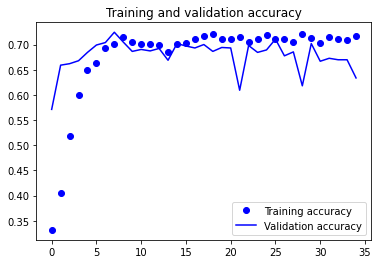

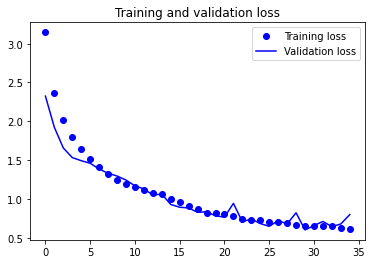

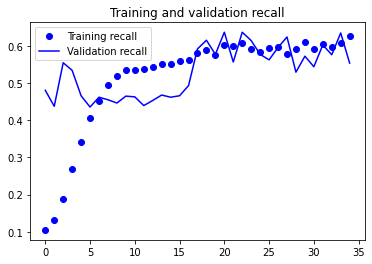


Training Evaluation:
34/34 [==============================] - 164s 5s/step - loss: 0.7584 - accuracy: 0.6422 - recall: 0.5408

Validation Evaluation:
9/9 [==============================] - 122s 14s/step - loss: 0.8166 - accuracy: 0.6389 - recall: 0.5417

Validation Confusion Matrix



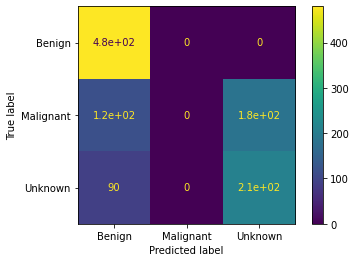

In [11]:
visualize_cnn(transfer_history3, transfer_model3, train_gen_transfer3, val_gen_transfer3, multi=True, labels=['Benign', 'Malignant', 'Unknown'])
